# Analysing SCF convergence

The goal of this example is to explain the differing convergence behaviour
of SCF algorithms depending on the choice of the mixing.
For this we look at the eigenpairs of the Jacobian governing the SCF convergence,
that is
$$
1 - α P^{-1} \varepsilon^\dagger \qquad \text{with} \qquad \varepsilon^\dagger = (1-\chi_0 K).
$$
where $α$ is the damping $P^{-1}$ is the mixing preconditioner
(e.g. `KerkerMixing`, `LdosMixing`)
and $\varepsilon^\dagger$ is the dielectric operator.

We thus investigate the largest and smallest eigenvalues of
$(P^{-1} \varepsilon^\dagger)$ and $\varepsilon^\dagger$.
The ratio of largest to smallest eigenvalue of this operator is the condition number
$$
\kappa = \frac{\lambda_\text{max}}{\lambda_\text{min}},
$$
which can be related to the rate of convergence of the SCF.
The smaller the condition number, the faster the convergence.
For more details on SCF methods, see Self-consistent field methods.

For our investigation we consider a crude aluminium setup:

In [1]:
using ASEconvert
using DFTK
using LazyArtifacts
import Main: @artifact_str # hide

ase_Al    = ase.build.bulk("Al"; cubic=true) * pytuple((4, 1, 1))
system_Al = attach_psp(pyconvert(AbstractSystem, ase_Al);
                       Al=artifact"pd_nc_sr_pbe_standard_0.4.1_upf/Al.upf")

FlexibleSystem(Al₁₆, periodic = TTT):
    bounding_box      : [    16.2        0        0;
                                0     4.05        0;
                                0        0     4.05]u"Å"

      .---------------------------------------.  
     /|                                       |  
    * |                                       |  
    |Al        Al        Al        Al         |  
    | |                                       |  
    | .--Al--------Al--------Al--------Al-----.  
    |/    Al        Al        Al        Al   /   
    Al--------Al--------Al--------Al--------*    


and we discretise:

In [2]:
model_Al = model_LDA(system_Al; temperature=1e-3, symmetries=false)
basis_Al = PlaneWaveBasis(model_Al; Ecut=7, kgrid=[1, 1, 1]);

On aluminium (a metal) already for moderate system sizes (like the 8 layers
we consider here) the convergence without mixing / preconditioner is slow:

In [3]:
# Note: DFTK uses the self-adapting LdosMixing() by default, so to truly disable
#       any preconditioning, we need to supply `mixing=SimpleMixing()` explicitly.
scfres_Al = self_consistent_field(basis_Al; tol=1e-12, mixing=SimpleMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -35.98102113779                   -0.86   10.0    475ms
  2   -35.94541311661   +   -1.45       -1.51    1.0   92.9ms
  3   +4.139026511907   +    1.60       -0.26    7.0    266ms
  4   -35.49192460718        1.60       -0.99    9.0    285ms
  5   -35.77662205009       -0.55       -1.22    3.0    189ms
  6   -35.95390966216       -0.75       -1.76    3.0    130ms
  7   -35.41753679481   +   -0.27       -1.19    4.0    146ms
  8   -35.98600485500       -0.25       -2.02    4.0    144ms
  9   -35.98914917926       -2.50       -2.14    2.0    126ms
 10   -35.98796216261   +   -2.93       -2.09    2.0    116ms
 11   -35.98964315168       -2.77       -2.67    2.0    122ms
 12   -35.98951487341   +   -3.89       -2.57    3.0    151ms
 13   -35.98975410136       -3.62       -3.23    2.0    118ms
 14   -35.98975725884       -5.50       -3.30    2.0    118ms
 15   -35

while when using the Kerker preconditioner it is much faster:

In [4]:
scfres_Al = self_consistent_field(basis_Al; tol=1e-12, mixing=KerkerMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -35.98177867685                   -0.86   11.0    460ms
  2   -35.98766508839       -2.23       -1.34    1.0    105ms
  3   -35.98595275297   +   -2.77       -1.60    2.0    113ms
  4   -35.98945034821       -2.46       -2.24    1.0   94.2ms
  5   -35.98949868131       -4.32       -2.45    4.0    187ms
  6   -35.98974210771       -3.61       -2.65    3.0    118ms
  7   -35.98972412347   +   -4.75       -2.83   10.0    191ms
  8   -35.98975394856       -4.53       -3.23    2.0    116ms
  9   -35.98976533882       -4.94       -3.46    3.0    151ms
 10   -35.98976646949       -5.95       -3.90    2.0    109ms
 11   -35.98976627280   +   -6.71       -4.11    4.0    143ms
 12   -35.98976659731       -6.49       -4.28    3.0    173ms
 13   -35.98976678210       -6.73       -5.07    2.0    109ms
 14   -35.98976678390       -8.75       -5.40    5.0    192ms
 15   -35

Given this `scfres_Al` we construct functions representing
$\varepsilon^\dagger$ and $P^{-1}$:

In [5]:
# Function, which applies P^{-1} for the case of KerkerMixing
Pinv_Kerker(δρ) = DFTK.mix_density(KerkerMixing(), basis_Al, δρ)

# Function which applies ε† = 1 - χ0 K
function epsilon(δρ)
    δV   = apply_kernel(basis_Al, δρ; ρ=scfres_Al.ρ)
    χ0δV = apply_χ0(scfres_Al, δV)
    δρ - χ0δV
end

epsilon (generic function with 1 method)

With these functions available we can now compute the desired eigenvalues.
For simplicity we only consider the first few largest ones.

In [6]:
using KrylovKit
λ_Simple, X_Simple = eigsolve(epsilon, randn(size(scfres_Al.ρ)), 3, :LM;
                              tol=1e-3, eager=true, verbosity=2)
λ_Simple_max = maximum(real.(λ_Simple))

[ Info: Arnoldi schursolve in iter 1, krylovdim = 3: 0 values converged, normres = (8.30e-01, 2.29e+00, 3.14e-02)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 4: 0 values converged, normres = (6.95e-02, 1.89e+00, 2.65e+00)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 5: 0 values converged, normres = (5.32e-03, 1.85e+00, 1.61e+00)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 6: 1 values converged, normres = (3.44e-04, 1.34e+00, 1.28e+00)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 7: 1 values converged, normres = (1.81e-05, 3.88e-01, 5.24e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 8: 1 values converged, normres = (5.28e-07, 6.77e-02, 1.75e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 9: 1 values converged, normres = (4.66e-08, 3.32e-02, 1.53e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 10: 1 values converged, normres = (9.02e-10, 5.85e-03, 4.58e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 11: 1 values converged, normres = (4.

44.38745212990846

The smallest eigenvalue is a bit more tricky to obtain, so we will just assume

In [7]:
λ_Simple_min = 0.952

0.952

This makes the condition number around 30:

In [8]:
cond_Simple = λ_Simple_max / λ_Simple_min

46.62547492637444

This does not sound large compared to the condition numbers you might know
from linear systems.

However, this is sufficient to cause a notable slowdown, which would be even more
pronounced if we did not use Anderson, since we also would need to drastically
reduce the damping (try it!).

 Having computed the eigenvalues of the dielectric matrix
we can now also look at the eigenmodes, which are responsible for
the bad convergence behaviour. The largest eigenmode for example:

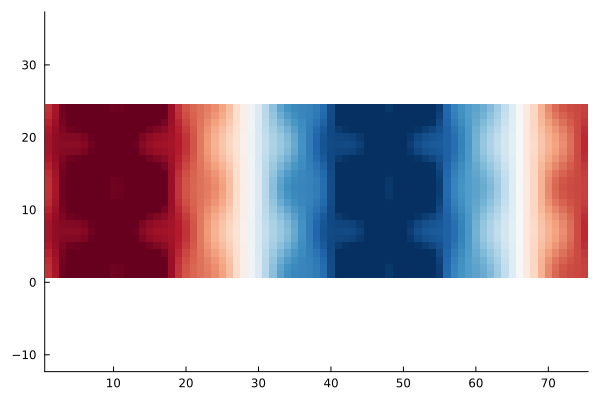

In [9]:
using Statistics
using Plots
mode_xy = mean(real.(X_Simple[1]), dims=3)[:, :, 1, 1]  # Average along z axis
heatmap(mode_xy', c=:RdBu_11, aspect_ratio=1, grid=false,
        legend=false, clim=(-0.006, 0.006))

This mode can be physically interpreted as the reason why this SCF converges
slowly. For example in this case it displays a displacement of electron
density from the centre to the extremal parts of the unit cell. This
phenomenon is called charge-sloshing.

We repeat the exercise for the Kerker-preconditioned dielectric operator:

[ Info: Arnoldi schursolve in iter 1, krylovdim = 3: 0 values converged, normres = (9.15e-01, 6.80e-02, 2.05e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 4: 0 values converged, normres = (5.87e-01, 4.73e-01, 1.23e-02)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 5: 0 values converged, normres = (2.15e-01, 3.48e-01, 9.30e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 6: 0 values converged, normres = (1.05e-01, 5.25e-01, 1.78e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 7: 0 values converged, normres = (2.96e-02, 1.95e-01, 1.24e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 8: 0 values converged, normres = (3.07e-02, 5.83e-01, 1.00e+00)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 9: 0 values converged, normres = (5.33e-02, 4.70e-01, 1.35e-01)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 10: 0 values converged, normres = (8.46e-03, 4.53e-02, 1.70e-02)
[ Info: Arnoldi schursolve in iter 1, krylovdim = 11: 1 values converged, normres = (5.

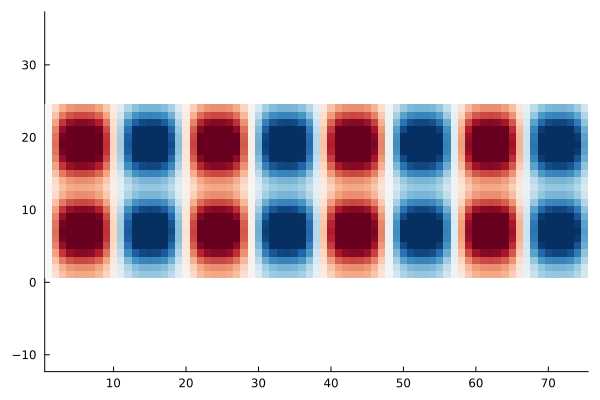

In [10]:
λ_Kerker, X_Kerker = eigsolve(Pinv_Kerker ∘ epsilon,
                              randn(size(scfres_Al.ρ)), 3, :LM;
                              tol=1e-3, eager=true, verbosity=2)

mode_xy = mean(real.(X_Kerker[1]), dims=3)[:, :, 1, 1]  # Average along z axis
heatmap(mode_xy', c=:RdBu_11, aspect_ratio=1, grid=false,
        legend=false, clim=(-0.006, 0.006))

Clearly the charge-sloshing mode is no longer dominating.

The largest eigenvalue is now

In [11]:
maximum(real.(λ_Kerker))

4.6854608388148264

Since the smallest eigenvalue in this case remains of similar size (it is now
around 0.8), this implies that the conditioning improves noticeably when
`KerkerMixing` is used.

**Note:** Since LdosMixing requires solving a linear system at each
application of $P^{-1}$, determining the eigenvalues of
$P^{-1} \varepsilon^\dagger$ is slightly more expensive and thus not shown. The
results are similar to `KerkerMixing`, however.

We could repeat the exercise for an insulating system (e.g. a Helium chain).
In this case you would notice that the condition number without mixing
is actually smaller than the condition number with Kerker mixing. In other
words employing Kerker mixing makes the convergence *worse*. A closer
investigation of the eigenvalues shows that Kerker mixing reduces the
smallest eigenvalue of the dielectric operator this time, while keeping
the largest value unchanged. Overall the conditioning thus workens.

**Takeaways:**
- For metals the conditioning of the dielectric matrix increases steeply with system size.
- The Kerker preconditioner tames this and makes SCFs on large metallic
  systems feasible by keeping the condition number of order 1.
- For insulating systems the best approach is to not use any mixing.
- **The ideal mixing** strongly depends on the dielectric properties of
  system which is studied (metal versus insulator versus semiconductor).